In [1]:
import sys
from pathlib import Path

# Đang ở: WorldLevel_DIP/notebooks
PROJECT_ROOT = Path.cwd().parent          # -> WorldLevel_DIP
print("PROJECT_ROOT:", PROJECT_ROOT)

# Thêm project root vào sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


PROJECT_ROOT: /home/dangkhoi/dev/Projects/WorldLevel_DIP


In [2]:
import torch
from torch.utils.data import DataLoader, random_split

from src.dataset import WLASLKeypointDataset, load_label_map
from src.model import GRUClassifier
from src.train_utils import train_one_epoch, eval_one_epoch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Dataset + Dataloader

In [3]:
label_map = load_label_map()
num_classes = len(label_map)
print("label_map:", label_map)
print("num_classes:", num_classes)

dataset = WLASLKeypointDataset()
len(dataset)


label_map: {'class_name': 0, 'a': 1, 'abdomen': 2, 'adapt': 3, 'adjective': 4, 'admit': 5, 'adult': 6, 'adverb': 7, 'africa': 8, 'age': 9, 'ago': 10, 'airplane': 11, 'alone': 12, 'alphabet': 13, 'always': 14, 'amazing': 15, 'and': 16, 'another': 17, 'any': 18, 'apartment': 19, 'apostrophe': 20, 'appetite': 21, 'apple': 22, 'april': 23, 'arizona': 24, 'asia': 25, 'ask': 26, 'asl': 27, 'assume': 28, 'audiology': 29, 'august': 30, 'aunt': 31, 'aware': 32, 'away': 33, 'b': 34, 'back': 35, 'bad': 36, 'bald': 37, 'bar': 38, 'barely': 39, 'bathroom': 40, 'beautiful': 41, 'because': 42, 'become': 43, 'bee': 44, 'beer': 45, 'benefit': 46, 'best': 47, 'better': 48, 'bird': 49, 'birthday': 50, 'bitter': 51, 'black': 52, 'blind': 53, 'blow': 54, 'blue': 55, 'bored': 56, 'boss': 57, 'bowling': 58, 'boy': 59, 'brain': 60, 'broke': 61, 'brown': 62, 'brush': 63, 'buffalo': 64, 'bug': 65, 'bull': 66, 'burp': 67, 'bus': 68, 'button': 69, 'bye': 70, 'cabbage': 71, 'cafeteria': 72, 'california': 73, 'came

3616

In [4]:
dataset[0]  # (seq, label)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 1)

### Split train/val/test

In [ ]:
# --- Thay thế toàn bộ Cell 5 bằng đoạn này ---

# 1. Tính toán kích thước chia tập
total_count = len(dataset)
train_size = int(0.7 * total_count)
val_size   = int(0.15 * total_count)
test_size  = total_count - train_size - val_size

# 2. Chia Index ngẫu nhiên (dùng dataset thường làm gốc để chia)
# Dùng manual_seed(42) để đảm bảo lần chạy nào cũng chia video giống nhau
generator = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=generator
)

# 3. KỸ THUẬT QUAN TRỌNG: Áp dụng Augmentation chỉ cho tập Train
# B1: Khởi tạo một dataset mới CÓ bật augmentation
train_dataset_with_aug = WLASLKeypointDataset(augment=True)

# B2: "Tráo" dataset nguồn của tập train_subset sang bản có augmentation
# train_subset vẫn giữ danh sách index cũ (để không bị trùng video với val/test),
# nhưng khi lấy dữ liệu nó sẽ lấy từ 'train_dataset_with_aug'
train_subset.dataset = train_dataset_with_aug

# 4. Tạo DataLoader như bình thường
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_subset, batch_size=8, shuffle=False)

print(f"Data Split Complete:")
print(f"Train size: {len(train_subset)} (Augmented=True)")
print(f"Val size:   {len(val_subset)} (Augmented=False)")
print(f"Test size:  {len(test_subset)} (Augmented=False)")

Data Split Complete:
Train size: 2531 (Augmented=True)
Val size:   542 (Augmented=False)
Test size:  543 (Augmented=False)


# Define model - losss - optimize

In [6]:
FEATURE_DIM = 63    # giống trong preprocess
HIDDEN_SIZE = 128
NUM_LAYERS = 1

model = GRUClassifier(
    input_size=FEATURE_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=0.3,
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [7]:
# Cấu hình khuyến nghị cho 500 class
model = GRUClassifier(
    input_size=63,       # Giữ nguyên (hoặc 126 nếu dùng 2 tay)
    hidden_size=256,     # Tăng từ 128 -> 256 hoặc 512
    num_layers=2,        # Tăng từ 1 -> 2 hoặc 3 lớp chồng lên nhau
    num_classes=500,     # Số lớp output
    dropout=0.3          # Giữ dropout để tránh overfitting
).to(device)

# Train loop

In [8]:
import matplotlib.pyplot as plt

EPOCHS = 200

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = eval_one_epoch(
        model, val_loader, criterion, device
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"[{epoch+1}/{EPOCHS}] "
        f"train_loss={train_loss:.4f}, acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, acc={val_acc:.4f}"
    )


/opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from src.dataset import load_label_map
label_map = load_label_map()
idx2label = {v: k for k, v in label_map.items()}

model.eval()
samples = 0

for seq, labels in val_loader:
    seq = torch.tensor(seq, dtype=torch.float32, device=device)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    with torch.no_grad():
        outputs = model(seq)
        preds = outputs.argmax(dim=1)

    for p, t in zip(preds.cpu().numpy(), labels.cpu().numpy()):
        print("pred:", idx2label[p], " | true:", idx2label[t])
        samples += 1
        if samples >= 20:
            break
    if samples >= 20:
        break


pred: best  | true: and
pred: hamburger  | true: silly
pred: mirror  | true: west
pred: dog  | true: buffalo
pred: europe  | true: know
pred: concept  | true: company
pred: airplane  | true: airplane
pred: bug  | true: age
pred: pink  | true: buffalo
pred: sleepy  | true: fourth
pred: broke  | true: precious
pred: june  | true: june
pred: ten  | true: not
pred: feel  | true: take turns
pred: ago  | true: pretty
pred: down  | true: must
pred: deaf  | true: snob
pred: thirsty  | true: motivate
pred: old  | true: hard of hearing
pred: boy  | true: common sense


/tmp/ipykernel_100141/3861490091.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32, device=device)
/tmp/ipykernel_100141/3861490091.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)


# Evaluate on test set

In [ ]:
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)
print("Test loss:", test_loss)
print("Test acc :", test_acc)


Test loss: 5.404515791993115
Test acc : 0.0718232044198895


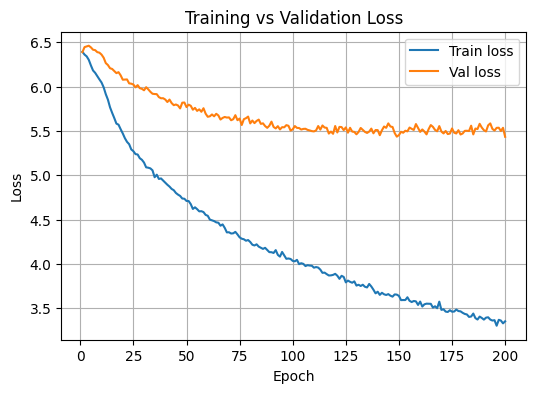

In [ ]:
%matplotlib inline

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


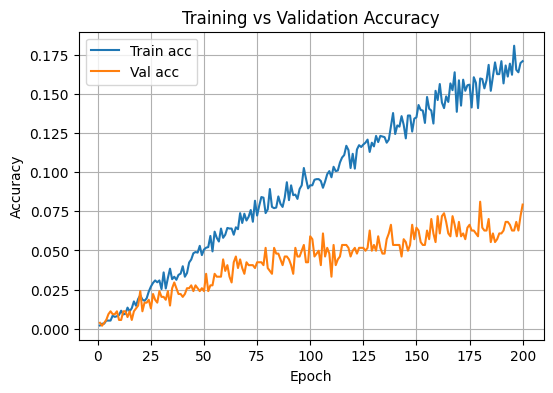

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# torch.save(model.state_dict(), "word_level_gru.pth")
